In [1]:
import os
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import skimage.morphology as morph
import scipy.ndimage.morphology as ndi_morph
from skimage import measure
from scipy import misc

from model import ResUNet34
import utils
from accuracy import compute_metrics
import time

from options import Options
from my_transforms import get_transforms

In [2]:
opt = Options(isTrain=False)
opt.parse()
#opt.save_options()
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(x) for x in opt.test['gpus'])

img_dir = opt.test['img_dir']
label_dir = opt.test['label_dir']
save_dir = opt.test['save_dir']
model_path = opt.test['model_path']
save_flag = opt.test['save_flag']

# data transforms
test_transform = get_transforms(opt.transform['test'])

model = ResUNet34(pretrained=opt.model['pretrained'])
model = torch.nn.DataParallel(model)
model = model.cuda()
cudnn.benchmark = True

# ----- load trained model ----- #
print("=> loading trained model")
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded model at epoch {}".format(checkpoint['epoch']))
model = model.module

# switch to evaluate mode
model.eval()
counter = 0
print("=> Test begins:")

img_names = os.listdir(img_dir)

=> loading trained model
=> loaded model at epoch 70
=> Test begins:


In [3]:
def get_probmaps(input, model, opt):
    size = opt.test['patch_size']
    overlap = opt.test['overlap']

    if size == 0:
        with torch.no_grad():
            output = model(input.cuda())
    else:
        output = utils.split_forward(model, input, size, overlap)
    output = output.squeeze(0)
    prob_maps = F.softmax(output, dim=0).cpu().numpy()

    return prob_maps

In [4]:
for img_name in img_names[1:]:
    # load test image
    print('=> Processing image {:s}'.format(img_name))
    img_path = '{:s}/{:s}'.format(img_dir, img_name)
    img = Image.open(img_path)
    ori_h = img.size[1]
    ori_w = img.size[0]
    name = os.path.splitext(img_name)[0]
    label_path = '{:s}/{:s}_label.png'.format(label_dir, name)
    gt = misc.imread(label_path)

    input = test_transform((img,))[0].unsqueeze(0)

    print('\tComputing output probability maps...')
    prob_maps = get_probmaps(input, model, opt)
    pred = np.argmax(prob_maps, axis=0)  # prediction

    pred_labeled = measure.label(pred)
    pred_labeled = morph.remove_small_objects(pred_labeled, opt.post['min_area'])
    pred_labeled = ndi_morph.binary_fill_holes(pred_labeled > 0)
    pred_labeled = measure.label(pred_labeled)
    break

=> Processing image TCGA-21-5784-01Z-00-DX1:512_1024_x_512_1024.png
	Computing output probability maps...


/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
pred.shape

(488, 488)

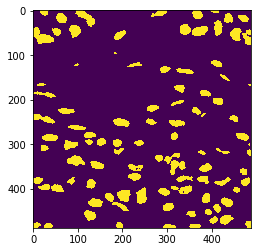

In [7]:
plt.imshow(pred)
plt.show()